# Recommendation Systems

## Table of Contents

- [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
- [Rank Based Recommendations](#Rank)<br>
- [User-User Based Collaborative Filtering](#User-User)<br>
- [Content Based Recommendations](#Content-Recs)<br>
- [Matrix Factorization](#Matrix-Fact)<br>

In [180]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('abc')
nltk.download('webtext')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import nps_chat

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Displaying sample of data
df.sample(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package abc to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\abc.zip.
[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\webtext.zip.


,article_id,title,email
44159,260.0,the machine learning database,5b5d25e71f2869a68ec06fa31a4e62449beee396
45613,1169.0,annual precipitation by country 1990-2009,ba337a635a4fe63fa26279413d834e4292c206f1
41249,1054.0,access mysql with r,421a025f86f56203242c35c913717ac295fde4d6
13327,1314.0,healthcare python streaming application demo,c615f1184fd65ccea021e7014c91e0f9093ef39d
38447,1170.0,"apache spark lab, part 1: basic concepts",3205d3d2430c055fd0ec1419a905490edde4dc68
21642,1185.0,classify tumors with machine learning,8510a5010a5d4c89f5b07baac6de80cd12cfaf93
32317,295.0,awesome deep learning papers,c60bb0a50c324dad0bffd8809d121246baef372b
4278,1008.0,2875 hugo larochelle's neural network & dee...,4aa994cbdd6a9db1dad5a7bb202db728809143c6
23733,692.0,15 page tutorial for r,a239da1fe9abe3cb21ea28a7e7f671373fd4dca9
42275,2.0,"this week in data science (april 18, 2017)",fa4ecb48d3940a645f0bac0c774279c5e9958832


### <a class="anchor" id="Exploratory-Data-Analysis">Exploratory Data Analysis</a>

***What is the distribution of how many articles a user interacts with in the dataset?***

In [181]:
# Dimensions of data frame
df.shape

(45993, 3)

In [182]:
# Info of the data
df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [183]:
# Summary of the dataset
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [184]:
df.groupby('email').count()['title']

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: title, Length: 5148, dtype: int64

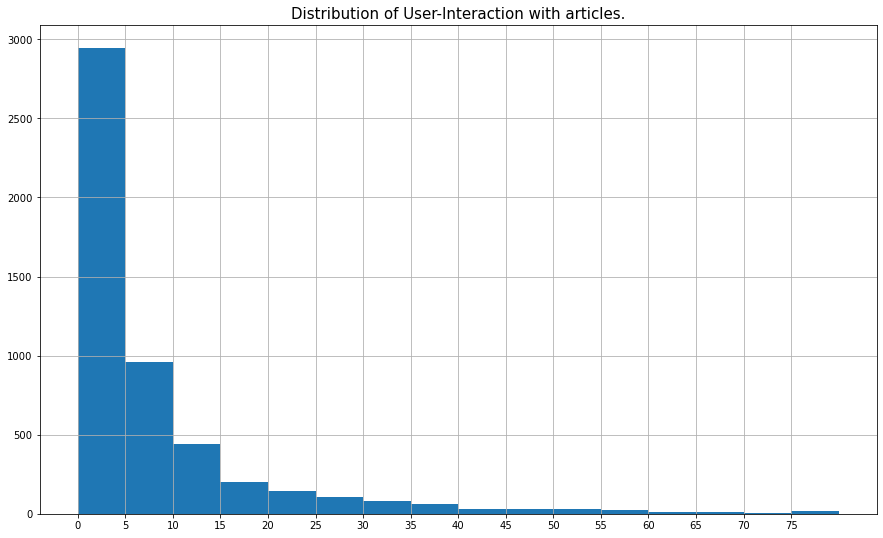

In [185]:
# Creating user_interaction data frame
user_interaction = df.groupby('email').count()['article_id']

# Plotting distribution
plt.figure(figsize = (15, 9))
user_interaction.hist(bins = np.arange(0, 85, 5))
plt.xticks(np.arange(0, 80, 5));

plt.title("Distribution of User-Interaction with articles.", fontsize = 15);

***Explore and remove duplicate articles from the df_content dataframe.*** 

In [186]:
# Finding and exploring duplicate articles
df_content.sample(10)

,doc_body,doc_description,doc_full_name,doc_status,article_id
264,Skip to main content IBM developerWorks / Deve...,"Meet the new spark-cloudant connector, for add...","Introducing spark-cloudant, an open source Spa...",Live,264
909,Brilliantly wrong thoughts on science and prog...,A very flexible tool to create readable analys...,Jupyter (IPython) notebooks features,Live,906
577,G. Adam Cox Blocked Unblock Follow Following M...,In my previous life I was a particle physicist...,Offline and radioactively clean – IBM Watson D...,Live,576
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539
345,The secondary index provides a way for you to ...,The secondary index provides a way for you to ...,Use the secondary index in Cloudant,Live,345
779,YOUR OWN WEATHER FORECAST IN A PYTHON NOTEBOOK...,Use Weather Company Data APIs and matplotlib t...,Your own weather forecast in a Python notebook,Live,776
70,Skip navigation Upload Sign in SearchLoading.....,"Bradley Holt, IBM Cloudant Web and mobile apps...",Offline-First Apps with PouchDB,Live,70
715,COMPOSE NOTES - POSTGRESQL CONNECTION LIMIT CO...,PostgreSQL 9.5 users can now control the numbe...,PostgreSQL connection limit control,Live,713
422,Homepage IBM Watson Data Lab Follow Sign in / ...,Our goal wasn’t to build the best event concie...,Navigating SXSW via cognitive chatbot – IBM Wa...,Live,421
1026,Enterprise Pricing Articles Sign in Free 30-Da...,"Varun Singh, a software engineer at IBM's Wats...",Redis and MongoDB in the biomedical domain,Live,1021


In [187]:
# Info on content data frame
df_content.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [188]:
# Removing any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = 'article_id', keep = 'first', inplace = True)

- The number of unique articles that have an interaction with a user.  
- The number of unique articles in the dataset (whether they have any interactions or not).<br>
- The number of unique users in the dataset. (excluding null values)<br> 
- The number of user-article interactions in the dataset.

In [189]:
# The number of unique articles that have an interaction with a user.
df.groupby(['email'])['article_id'].unique().shape

(5148,)

In [190]:
# The number of unique articles in the dataset (whether they have any interactions or not).
df.article_id.unique().shape

(714,)

In [191]:
# The number of unique users in the dataset. (excluding null values)
df.email.drop_duplicates().unique().shape

(5149,)

In [192]:
# The number of user-article interactions in the dataset.
df.shape

(45993, 3)

In [193]:
unique_articles = 714,
total_articles = 1051, 
unique_users = 5148,
user_article_interactions = 45993

*Finding the most viewed **article_id**, as well as how often it was viewed.  After talking to the people, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.*

In [194]:
df.article_id.value_counts().sort_values(ascending = False).head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [195]:
most_viewed_article_id = 1429, # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [196]:
# Mapping the user email to a user_id column and remove the email column

# mapper function user_email to user_id
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

# calling mapper
email_encoded = email_mapper()

del df['email']

df['user_id'] = email_encoded

# Showing sample
df.sample(5)

,article_id,title,user_id
1621,495.0,top 10 machine learning algorithms for beginners,11
38088,1296.0,fortune 100 companies,4268
10445,1047.0,a comparison of logistic regression and naive ...,1354
21045,346.0,fighting gerrymandering: using data science to...,1507
28874,62.0,data visualization: the importance of excludin...,3353


In [197]:
# email id is not like email so we replace it with user_id 
df.head(5)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Rank-Based Recommendations</a>

*Function below to return the **n** top articles ordered with most interactions as the top.*

In [198]:
def get_top_article_ids(n, df = df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_ids = df.article_id.value_counts().sort_values(ascending = False).head(n).index
    return top_articles_ids # Returns the top article ids

def get_top_articles(n, df = df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_ids = df.loc[df.article_id.isin(get_top_article_ids(n, df)) & ~df.article_id.duplicated()]
    
    top_articles = top_articles_ids.title.values
    
    return top_articles # Return the top article titles from df (not df_content)

In [199]:
print(get_top_articles(10))
print()
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')


### <a class="anchor" id="User-User">User-User Based Collaborative Filtering</a>


*Function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.*  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [201]:
~df.groupby(['user_id', 'article_id'])['title'].max().unstack().isna()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5146,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5147,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [202]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    map_1_0 = {True:1, False:0}
    
    user_item_matrix = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item_matrix = ~ user_item_matrix.isna()
    
    user_item_matrix = user_item_matrix.applymap(lambda x: map_1_0[x])
    return user_item_matrix # returns the user_item matrix 

user_item = create_user_item_matrix(df)

In [203]:
## Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


*Function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.* 

In [204]:
user_item.loc[2].sum()

6

In [205]:
user_item.dot(user_item.loc[1]).sort_values().drop(1)

user_id
2575     0
2911     0
2916     0
2918     0
2920     0
        ..
4459    15
203     15
3782    17
23      17
3933    35
Length: 5148, dtype: int64

In [206]:
def find_similar_users(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    similarity = similarity.sort_values(ascending = False)
    
    # remove the own user's id
    similarity.drop(user_id, inplace = True)
    
    # create list of just the ids
    most_similar_users = list(similarity.index)
    return most_similar_users # return a list of the users in order from most to least similar
        

In [207]:
# Checking of function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


*Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles you can recommend.  Functions below to return the articles we would recommend to each user.*

In [208]:
df[df.article_id.isin([2,4,8,20])]

,article_id,title,user_id
484,20.0,working interactively with rstudio and noteboo...,197
791,20.0,working interactively with rstudio and noteboo...,266
2305,20.0,working interactively with rstudio and noteboo...,563
2677,2.0,"this week in data science (april 18, 2017)",676
2745,20.0,working interactively with rstudio and noteboo...,714
...,...,...,...
45880,2.0,"this week in data science (april 18, 2017)",5140
45896,2.0,"this week in data science (april 18, 2017)",5140
45931,2.0,"this week in data science (april 18, 2017)",5140
45934,20.0,working interactively with rstudio and noteboo...,5140


In [209]:
article_ids = [2,4,8,10,12,14]

In [210]:
articles = df[df.article_id.isin(article_ids)]
articles = articles.drop_duplicates('article_id')

In [211]:
for item in articles.title.values:
    print(item)

got zip code data? prep it for analytics. – ibm watson data lab – medium
timeseries data analysis of iot events by using jupyter notebook
this week in data science (april 18, 2017)
data science bowl 2017
analyze ny restaurant data using spark in dsx


In [212]:
def get_article_names(article_ids, df = df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    articles = df[df.article_id.isin(article_ids)]
    
    articles = articles.drop_duplicates('article_id')
    
    article_names = [item for item in articles.title.values]
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Finding the places in which the user_item_matrix == 1 for that user
    user_id = int(user_id)
    
    article_ids = list(user_item.columns[np.where(user_item.loc[user_id] == 1)])
    
    # get article names for article_ids
    article_names = get_article_names(article_ids)
    
    article_ids = [str(item) for item in article_ids]
    
    return article_ids, article_names # return the ids and names

def user_user_recs(user_id, m = 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    recs = []
    seen_ids, seen_names = get_user_articles(user_id)
    
    for user in similar_users:
        ids, names = get_user_articles(user)
        
        # find ids that have not been read by user 
        not_seen = list(set(ids) - (set(seen_ids) & set(ids)))
        
        # add to recs
        recs.extend(not_seen)
        if len(recs) >= m:
            break
    
    recs = recs[:m]    
    return recs # return your recommendations for this user_id    

In [213]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['timeseries data analysis of iot events by using jupyter notebook',
 'dsx: hybrid mode',
 'use sql with data in hadoop python',
 'discover hidden facebook usage insights',
 'graph-based machine learning',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'data visualization playbook: telling the data story',
 'data tidying in data science experience',
 'what is smote in an imbalanced class setting (e.g. fraud detection)?',
 'web picks (week of 4 september 2017)']

In [214]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


*Now we are going to improve the consistency of the **user_user_recs** function from above.* 

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [215]:
def get_top_sorted_users(user_id, df = df, user_item = user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # finding similarity with dot procut or yiu can say cosine
    similarity = user_item.dot(user_item.loc[user_id])
    
    # Sorting by similarity
    similarity = similarity.sort_values(ascending = False)
    similarity.drop(user_id, inplace = True)
    similarity = similarity.to_frame('similarity').reset_index()
    
    # Number of interactions
    interactions = df.user_id.value_counts().to_frame('interactions')
    
    # Combine the interaction counts with similarity
    neighbors_df = similarity.merge(interactions, left_on = 'user_id', right_index = True)
    neighbors_df = neighbors_df.rename(columns = {'user_id':'neighbor_id'})
    
    neighbors_df.sort_values(by = ['similarity', 'interactions'], ascending = False, inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m = 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    user_id = int(user_id)
    try:
        #get read articles
        user_article_ids, user_article_names = get_user_articles(user_id)
    
    except KeyError: #user does not exist
        recs = get_top_article_ids(m)
        rec_names = get_article_names(recs)
        return recs, get_article_names(recs)
    
    #getting neighbors sorted by similarity
    neighbours = get_top_sorted_users(user_id).neighbor_id.values
    
    #getting top 300 articles (their ids), if outside of top 300 we dont want to recommend
    all_articles_sorted = get_top_article_ids(300)
    
    recs = []
    
    for user in neighbours:
        neighbour_article_ids, _ = get_user_articles(user)
        not_seen = list(set(neighbour_article_ids) - (set(user_article_ids) & set(neighbour_article_ids)))
        
        #sorting by highest ranked articles, add to list
        not_seen_sorted = list(set(all_articles_sorted) & set(not_seen))
        
        recs.extend(not_seen)
        if(len(recs)>=m):
            recs = recs[:m]
            break;
            
    rec_names = get_article_names(recs)
    return recs, rec_names

In [216]:
# Test
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['793.0', '12.0', '362.0', '1154.0', '1391.0', '1157.0', '1151.0', '880.0', '555.0', '1166.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'airbnb data for analytics: washington d.c. listings', 'analyzing data by using the sparkling.data library features', 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots', 'sudoku', '10 powerful features on watson data platform, no coding necessary', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: vienna listings', 'build a naive-bayes model with wml & dsx']


**If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?**

*We would not be able to use any recommendation that relies on user similarity. Since the new user has most likely not read any articles yet, we cannot generate a similarity metric, and if a user has only read one article that is also not necessarily the best to determine user similarity based on only one article.*

*We could however instead recommend based solely on a random subset of the best ranked (most interacted with) articles. This also makes a lot of sense for new users since they will likely want to explore the platform, and would probably like to start with some of the more popular articles. The downside of this is that it could potentially skew our recommendation alogithm later on as it would see users who have interacted with all the same articles and think they are similar, but this would only be because they were suggested the same articles to begin with. Also basing article popularity on number of interactions presents the challenge that articles that are recommended in the new user scenario are likely to get more hits, wich would further increase their chances of being show to the next new user.*

**Using existing functions, provide the top 10 recommended articles you would provide for the a new user. We can test function against our thoughts to make sure we are all on the same page with how we might make a recommendation.**

In [217]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs, new_user_recs_names = user_user_recs_part2(int(float(new_user)), 10) # Your recommendations here

In [218]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

AssertionError: Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users.

### <a class="anchor" id="Content-Recs">Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  We might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

Function body below is to create a content based recommender.

In [220]:
def tokenize(x):
    '''
    Tokenize any string into seperate words. 
    Use lemmatizer to break words down into core forms, and then keep only words with meaning

    Inputs
    x (str) - string to break down

    Outputs
    filtered (array, str) - words that are special to the string
    '''
    stop_words = set(stopwords.words('english')) | set(nltk.corpus.abc.words())
    tokens = word_tokenize(x) # Tokenizing
    lemmatizer = WordNetLemmatizer()
    
    cleaned_tokens = []
    
    for token in tokens:
        cleaned_token = lemmatizer.lemmatize(token).lower().strip()
        cleaned_tokens.append(cleaned_token)
    
    filtered = [word for word in cleaned_tokens if word not in stop_words and word.isalpha()]
    
    return filtered

In [226]:
def make_content_recs(id, user_id, m = 10, df = df):
    '''
    INPUT:
        id (str) - id of either user or article
        user_id (bool) - if true, make recs based on user
        m (int) - number of recommendations to give based on term
    OUTPUT:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended
        
    Description:
       This content based recommender looks at the articles the user has interacted with.
       It goes through each article title and using he NLTK library, finds the most common words
       (related to content) throughout all the articles.
              
       Based on these most common words, the recommender looks at the sums of words in
       the title of each article, and based on the number of matches as well as the
       general popularity of the article it gives back the best recommendations.
    '''
    if(user_id):
        user_id = id
        try:
            #getting already read articles
            article_ids, names = get_user_articles(user_id)
        
        except KeyError: #user does not exist
            print('Recommending Top Articles, ID Doesnt exist')
            recs = get_top_article_ids(m)
            recs_names = get_article_names(recs)
            return recs, recs_names
    
    else:
        article_ids = id
        
    title_data = df.drop_duplicates(subset = 'article_id') 
    titles = title_data[title_data.article_id.isin(list(map(float, article_ids)))].title
    
    #tokenizing the words in each article title
    title_words=[]
    tokenized = tokenize(titles.str.cat(sep = ' '))
    title_words.extend(tokenized)
    
    #finding the highest occuring words
    common_words = pd.value_counts(title_words).sort_values(ascending=False)[:10].index

    top_matches = {} 
    
    #counting number of occurences of each common word in other article titles
    for word in common_words:
        word_count = pd.Series(title_data.title.str.count(word).fillna(0))
        top_matches[word] = word_count
                    
    top_matches = pd.DataFrame(top_matches)
    top_matches['top_matches'] = top_matches.sum(axis = 1)
    top_matches['article_id'] = title_data.article_id.astype(float)
    
    #getting most interacted with articles
    article_occurences = pd.DataFrame({'occurences':df.article_id.value_counts()})

    #sorting matches by most popular articles
    top_matches = top_matches.merge(article_occurences, left_on = 'article_id', right_index = True)
    top_matches.sort_values(['top_matches', 'occurences'], ascending = False, inplace = True)    
    
    #dropping already read articles
    recs_df = top_matches[~top_matches.article_id.isin(list(map(float, article_ids)))]
    
    #getting record id and names
    recs = recs_df.article_id[:m].values.astype(str)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [227]:
# make recommendations for a brand new user
make_content_recs(int(float('0.0')), user_id = True)

# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(['1427.0'], user_id = False)

Recommending Top Articles, ID Doesnt exist


(array(['1159.0', '390.0', '1332.0', '1324.0', '241.0', '1422.0', '969.0',
        '729.0', '14.0', '254.0'], dtype='<U32'),
 ['got zip code data? prep it for analytics. – ibm watson data lab – medium',
  'ibm watson facebook posts for 2015',
  'intents & examples for ibm watson conversation',
  'use r dataframes & ibm watson natural language understanding',
  'pixiedust 1.0 is here! – ibm watson data lab',
  'i am not a data scientist – ibm watson data lab',
  'flightpredict ii: the sequel  – ibm watson data lab',
  'introducing ibm watson studio ',
  'apple, ibm add machine learning to partnership with watson-core ml coupling',
  'analyze facebook data using ibm watson and watson studio'])

In [231]:
# Exporting user_item_matrix
with open('user_item_matrix.pkl', 'wb') as file:
    pickle.dump(user_item, file)

### <a class="anchor" id="Matrix-Fact">Matrix Factorization</a>

*We will build use matrix factorization to make article recommendations.*

We should have already created a **user_item** matrix above in above parts. 

In [233]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.pkl')

In [240]:
# sample view of matrix
user_item_matrix.sample(10)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3801,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3520,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1068,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


We can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [241]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [245]:
print("     u           s         vt")
u.shape, s.shape, vt.shape

     u           s         vt


((5149, 5149), (714,), (714, 714))

*Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.*

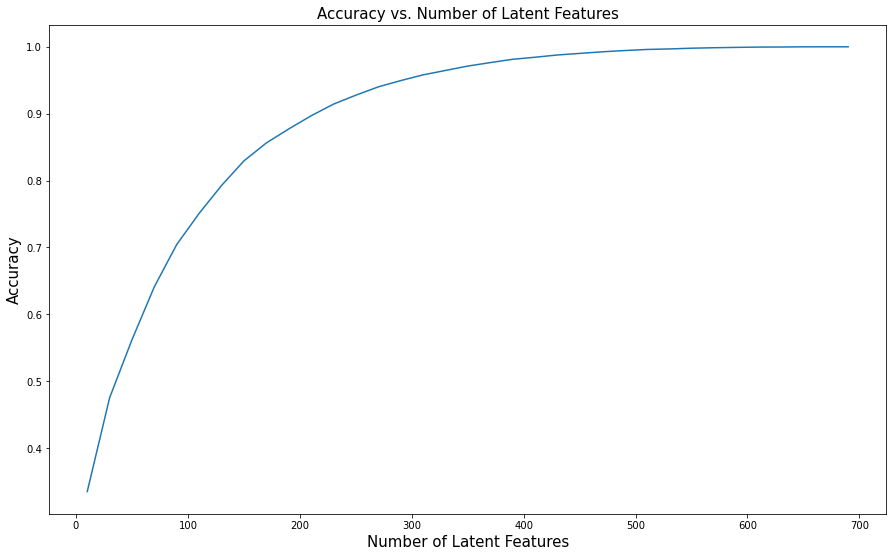

In [274]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.figure(figsize = (15, 9))
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df.shape[0]);
plt.xlabel('Number of Latent Features', fontsize = 15);
plt.ylabel('Accuracy', fontsize = 15);
plt.title('Accuracy vs. Number of Latent Features', fontsize = 15);

**From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data.**

In [251]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [252]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

*Now we use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.*  

In [265]:
train_idx = user_item_train.index

#Common indexes
common_idx = list(set(train_idx) & set(test_idx))

# Common columns
common_cols = user_item_train.columns.intersection(test_arts)

In [266]:
# fitting SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd

print("         u      s        vt")
u_train.shape, s_train.shape, vt_train.shape 

         u      s        vt


((4487, 4487), (714,), (714, 714))

In [267]:
# Finding common index in training and testing data
train_common_index = user_item_train.index.isin(test_idx)
train_common_col = user_item_train.columns.isin(test_arts)

In [268]:
u_test = u_train[train_common_index, :]
vt_test = vt_train[:, train_common_col]
print("    u            vt")
u_test.shape, vt_test.shape

    u            vt


((20, 4487), (714, 574))

In [269]:
# Testing data
user_item_test = user_item_test.loc[common_idx]

In [270]:
sum_train_errs = []
sum_test_errs = []
all_errs = []

# make predictions based on train_set SVD for the overlapping 20 users that are also in the test set
# compare these predictions with the actual test matrix to get errer

num_latent_features = np.arange(5, 710, 10)

# iterate through number of latent features to get predictions

for k in num_latent_features: 
    u_train_lat, s_train_lat, vt_train_lat = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k,:]
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    all_errs.append(1 - ((np.sum(user_item_test_preds) + np.sum(np.sum(user_item_test))) / (user_item_test.shape[0] * user_item_test.shape[1])))
    
    # calculating error
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[common_idx, :], user_item_test_preds)
    
    train_err = np.sum(np.sum(np.abs(diffs_train))) #first sum cols then rows
    sum_train_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test))) #first sum cols then rows
    sum_test_errs.append(test_err)

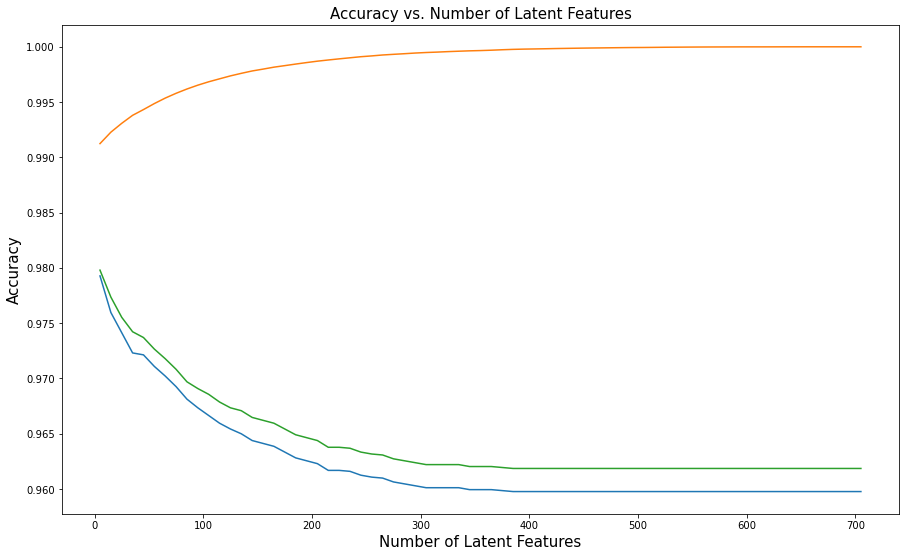

In [273]:
# Plotting errors
plt.figure(figsize = (15, 9))

plt.plot(num_latent_features, all_errs, label = 'all');
plt.plot(num_latent_features, 1 - (np.array(sum_train_errs) / (user_item_train.shape[0] * user_item_train.shape[1])), label = 'train');
plt.plot(num_latent_features, 1 - (np.array(sum_test_errs) / (user_item_test.shape[0] * user_item_test.shape[1])), label = 'test');

plt.xlabel('Number of Latent Features', fontsize = 15);
plt.ylabel('Accuracy', fontsize = 15);
plt.title('Accuracy vs. Number of Latent Features', fontsize = 15);